In [964]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import Utils.greeks as gr
import Utils.option_pricing_utils as opu

In [965]:
option_exposure = -100000  # Number of options held in portfolio that we want to hedge
S0 = 49
r = 0.05
sigma = 0.2
sigma2 = 0.2 # Realized vol of the path (greater than vol used in BS price - we underestimate)
q = 0
T = 20/52 #20/52
K = 50
type = 'c'

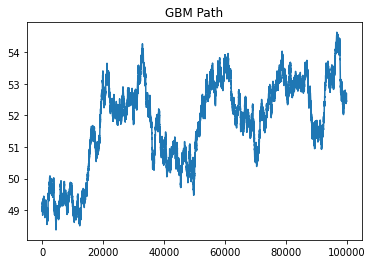

In [966]:
# Geometric Brownian Motion
# dSt = rSt dt + sigma*St dWt
M = 100000
W = np.random.normal(loc=0.0, scale=1.0, size=M)
T_array = np.linspace(T, 0, M)
dt = T_array[0] - T_array[1]

S = np.zeros(M)
S[0] = S0
for i in range(M-1):
    S[i+1] = S[i] + r*S[i]*dt + sigma2*S[i]*W[i]*np.sqrt(dt)

plt.plot(S)
plt.title('GBM Path')
plt.show()

In [967]:
delta_array = gr.get_delta(S, K, T_array, sigma, r, q, type)
gamma_array = gr.get_gamma(S, K, T_array, sigma, r, q, type)
theta_array = gr.get_theta(S, K, T_array, sigma, r, q, type)

c:\Users\Matthew\Documents\Python Scripts\Option_Pricing\Utils\option_pricing_utils.py:7: RuntimeWarning: divide by zero encountered in true_divide
  d1 = (np.log(S/K) + (r-q+sigma**2/2)*T)/(sigma*np.sqrt(T))
c:\Users\Matthew\Documents\Python Scripts\Option_Pricing\Utils\greeks.py:19: RuntimeWarning: invalid value encountered in true_divide
  return norm.pdf(d1)/(S*sigma*np.sqrt(T))
c:\Users\Matthew\Documents\Python Scripts\Option_Pricing\Utils\greeks.py:26: RuntimeWarning: invalid value encountered in true_divide
  theta_call = -r*K*np.exp(-r*T)*norm.cdf(d2) - S*norm.pdf(d1)*sigma/(2*np.sqrt(T))


#### Delta Hedging

In [968]:
summary_df = pd.DataFrame(list(zip(S, delta_array, gamma_array, theta_array)), columns=['Stock_Price', 'Delta', 'Gamma', 'Theta'])

In [969]:
summary_df['Shares_Held'] = -option_exposure*delta_array
summary_df['Shares_Purchased'] = -summary_df['Shares_Held'].sub(summary_df['Shares_Held'].shift(-1).fillna(0)).shift().fillna(-summary_df['Shares_Held'])
summary_df['Cost_of_Shares_Purchased'] = summary_df['Shares_Purchased'].mul(summary_df['Stock_Price'])
summary_df['Cumulative_Cost'] = summary_df['Cost_of_Shares_Purchased'].cumsum()
summary_df['Interest_Cost'] = summary_df['Cumulative_Cost']*(r*dt)
summary_df['Cumulative_Cost_Inc_Interest'] =  summary_df['Cumulative_Cost'].add(summary_df['Interest_Cost'].shift()).fillna(summary_df['Cumulative_Cost'])
summary_df['Portfolio_Delta'] = option_exposure*summary_df['Delta'] + summary_df['Shares_Held']*1
summary_df['Portfolio_Gamma'] = option_exposure*summary_df['Gamma'] + summary_df['Shares_Held']*0
summary_df['Portfolio_Theta'] = option_exposure*summary_df['Theta'] + summary_df['Shares_Held']*0

hedging_cost = -K*option_exposure - summary_df['Cumulative_Cost_Inc_Interest'].iloc[-1]  # Cash received for stock - total cost  

print(f'Hedging PnL = ${hedging_cost}')
summary_df

Hedging PnL = $4728117.597872235


,Stock_Price,Delta,Gamma,Theta,Shares_Held,Shares_Purchased,Cost_of_Shares_Purchased,Cumulative_Cost,Interest_Cost,Cumulative_Cost_Inc_Interest,Portfolio_Delta,Portfolio_Gamma,Portfolio_Theta
0,49.000000,-0.478395,0.065544,-1.852947,-47839.533893,-47839.533893,-2.344137e+06,-2.344137e+06,-0.450800,-2.344137e+06,0.0,-6554.403935,185294.741703
1,48.995521,-0.478690,0.065553,-1.852080,-47868.965584,-29.431690,-1.442021e+03,-2.345579e+06,-0.451077,-2.345580e+06,0.0,-6555.296438,185207.992076
2,49.009250,-0.477791,0.065527,-1.854793,-47779.062236,89.903347,4.406096e+03,-2.341173e+06,-0.450230,-2.341174e+06,0.0,-6552.685796,185479.293635
3,49.003178,-0.478189,0.065539,-1.853616,-47818.932990,-39.870754,-1.953794e+03,-2.343127e+06,-0.450606,-2.343127e+06,0.0,-6553.892682,185361.594302
4,49.007934,-0.477878,0.065530,-1.854564,-47787.839953,31.093037,1.523806e+03,-2.341603e+06,-0.450313,-2.341604e+06,0.0,-6553.007628,185456.403828
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,52.475836,0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000e+00,2.718823e+05,0.052286,2.718824e+05,0.0,0.000000,0.000000
99996,52.463246,0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000e+00,2.718823e+05,0.052286,2.718824e+05,0.0,0.000000,0.000000
99997,52.471169,0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000e+00,2.718823e+05,0.052286,2.718824e+05,0.0,0.000000,0.000000
99998,52.469771,0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000e+00,2.718823e+05,0.052286,2.718824e+05,0.0,0.000000,0.000000


In [970]:
profit_df = summary_df[['Stock_Price', 'Interest_Cost', 'Portfolio_Delta', 'Portfolio_Gamma', 'Portfolio_Theta', 'Shares_Held']].copy()
profit_df['Stock_Ret'] = profit_df['Stock_Price'].div(profit_df['Stock_Price'].shift()) - 1
profit_df['Stock_Change'] = profit_df['Stock_Price'].sub(profit_df['Stock_Price'].shift())
profit_df['BS_Option_Price'] = opu.get_bs_price_analytical(S, K, T_array, sigma, r, q, type, display_result=False)
profit_df['Option_Exposure'] = option_exposure*profit_df['BS_Option_Price']
profit_df['Share_Exposure'] = profit_df['Shares_Held'].mul(profit_df['Stock_Price'])
profit_df['Option_PnL'] = -profit_df['Option_Exposure'].shift().sub(profit_df['Option_Exposure'])
profit_df['Share_PnL'] = profit_df['Share_Exposure'].mul(profit_df['Stock_Ret'].shift(-1)).shift()
profit_df['Portfolio_PnL'] = profit_df['Share_PnL'].add(profit_df['Option_PnL'])
profit_df['Projected_Portfolio_Pnl_Delta'] = profit_df['Portfolio_Delta'].shift().mul(profit_df['Stock_Change'])
profit_df['Projected_Portfolio_Pnl_Delta_Gamma'] = profit_df['Portfolio_Delta'].shift().mul(profit_df['Stock_Change']) + 1/2*profit_df['Portfolio_Gamma'].shift().mul(profit_df['Stock_Change']**2)
profit_df['Projected_Portfolio_Pnl_Delta_Gamma_Theta'] = profit_df['Portfolio_Theta'].shift().mul(dt) + profit_df['Portfolio_Delta'].shift().mul(profit_df['Stock_Change']) + 1/2*profit_df['Portfolio_Gamma'].shift().mul(profit_df['Stock_Change']**2)
profit_df['Projected_Portfolio_Pnl_Delta_Theta'] = profit_df['Portfolio_Theta'].shift().mul(dt) + profit_df['Portfolio_Delta'].shift().mul(profit_df['Stock_Change'])
profit_df['Projected_Portfolio_Pnl_Delta_Gamma_Theta_Interest'] = profit_df['Portfolio_Theta'].shift().mul(dt) + profit_df['Portfolio_Delta'].shift().mul(profit_df['Stock_Change']) + 1/2*profit_df['Portfolio_Gamma'].shift().mul(profit_df['Stock_Change']**2) - profit_df['Interest_Cost']

profit_df = profit_df.astype(float).round(4)
profit_df

c:\Users\Matthew\Documents\Python Scripts\Option_Pricing\Utils\option_pricing_utils.py:7: RuntimeWarning: divide by zero encountered in true_divide
  d1 = (np.log(S/K) + (r-q+sigma**2/2)*T)/(sigma*np.sqrt(T))


,Stock_Price,Interest_Cost,Portfolio_Delta,Portfolio_Gamma,Portfolio_Theta,Shares_Held,Stock_Ret,Stock_Change,BS_Option_Price,Option_Exposure,Share_Exposure,Option_PnL,Share_PnL,Portfolio_PnL,Projected_Portfolio_Pnl_Delta,Projected_Portfolio_Pnl_Delta_Gamma,Projected_Portfolio_Pnl_Delta_Gamma_Theta,Projected_Portfolio_Pnl_Delta_Theta,Projected_Portfolio_Pnl_Delta_Gamma_Theta_Interest
0,49.0000,-0.4508,0.0,-6554.4039,185294.7417,-47839.5339,NaN,NaN,2.4482,-244817.5441,-2.344137e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,48.9955,-0.4511,0.0,-6555.2964,185207.9921,-47868.9656,-0.0001,-0.0045,2.4503,-245031.1472,-2.345365e+06,-213.6030,214.2496,0.6466,-0.0,-0.0657,0.6469,0.7127,1.0980
2,49.0093,-0.4502,0.0,-6552.6858,185479.2936,-47779.0622,0.0003,0.0137,2.4437,-244373.8645,-2.341616e+06,657.2826,-657.1869,0.0957,0.0,-0.6178,0.0946,0.7123,0.5448
3,49.0032,-0.4506,0.0,-6553.8927,185361.5943,-47818.9330,-0.0001,-0.0061,2.4466,-244663.4139,-2.343280e+06,-289.5494,290.1415,0.5921,-0.0,-0.1208,0.5926,0.7134,1.0432
4,49.0079,-0.4503,0.0,-6553.0076,185456.4038,-47787.8400,0.0001,0.0048,2.4444,-244435.3456,-2.341983e+06,228.0684,-227.4292,0.6392,0.0,-0.0741,0.6388,0.7129,1.0891
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,52.4758,0.0523,0.0,0.0000,0.0000,0.0000,-0.0009,-0.0468,0.0000,-0.0000,0.000000e+00,-0.0000,-0.0000,-0.0000,-0.0,0.0000,0.0000,0.0000,-0.0523
99996,52.4632,0.0523,0.0,0.0000,0.0000,0.0000,-0.0002,-0.0126,0.0000,-0.0000,0.000000e+00,-0.0000,-0.0000,-0.0000,-0.0,0.0000,0.0000,0.0000,-0.0523
99997,52.4712,0.0523,0.0,0.0000,0.0000,0.0000,0.0002,0.0079,0.0000,-0.0000,0.000000e+00,-0.0000,0.0000,0.0000,0.0,0.0000,0.0000,0.0000,-0.0523
99998,52.4698,0.0523,0.0,0.0000,0.0000,0.0000,-0.0000,-0.0014,0.0000,-0.0000,0.000000e+00,-0.0000,-0.0000,-0.0000,-0.0,0.0000,0.0000,0.0000,-0.0523


In [971]:
print(profit_df['Portfolio_PnL'].sum()) # Actual PnL of the portfolio
print(profit_df['Projected_Portfolio_Pnl_Delta_Gamma'].sum()) # Projected PnL of Delta-Hedged Portfolio Including Delta, Gamma at time t
print(profit_df['Projected_Portfolio_Pnl_Delta_Gamma_Theta'].sum()) # Projected PnL of Delta-Hedged Portfolio Including Delta, Gamma, Theta at time t
print(profit_df['Projected_Portfolio_Pnl_Delta_Gamma_Theta_Interest'].sum()) # Projected PnL of Delta-Hedged Portfolio Including Delta, Gamma, Theta at time t, including borring costs

-27064.793700000006
-141393.94809999995
-27069.603999999992
-4366.821400000001


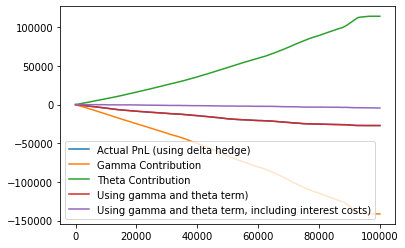

In [972]:
plt.plot(profit_df['Portfolio_PnL'].cumsum(), label='Actual PnL (using delta hedge)')
plt.plot(profit_df['Projected_Portfolio_Pnl_Delta_Gamma'].cumsum(), label='Gamma Contribution')
plt.plot(profit_df['Projected_Portfolio_Pnl_Delta_Theta'].cumsum(), label='Theta Contribution')
plt.plot(profit_df['Projected_Portfolio_Pnl_Delta_Gamma_Theta'].cumsum(), label='Using gamma and theta term)')
plt.plot(profit_df['Projected_Portfolio_Pnl_Delta_Gamma_Theta_Interest'].cumsum(), label='Using gamma and theta term, including interest costs)')

plt.legend()
plt.show()

In [973]:
(profit_df['Projected_Portfolio_Pnl_Delta_Gamma'] - profit_df['Projected_Portfolio_Pnl_Delta_Theta']).max()

0.0

In [974]:
profit_df['Share_PnL'].sum()

-271882.3610999999

In [975]:
profit_df['Option_PnL'].sum()

244817.54999999993

In [976]:
profit_df['Interest_Cost'].sum()

-22703.221100000006

In [977]:
total_hedging_cost = profit_df['Interest_Cost'].sum() - profit_df['Share_PnL'].sum()
discounted_hedging_cost = np.exp(-r*T)*total_hedging_cost
print(discounted_hedging_cost)

244433.0155413676
